# **POC de Modelo de Sistema de Recomendação para o SINTEGRE**

# Montando o Drive


In [1]:
# Montar o drive para que o nosso script consiga acessar a base de dados.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/BIMaster-Elvis/PROJ/TCC") 

In [3]:
!ls 

Modelo.ipynb		    Treino_RecSys_Elvis.ipynb
model.png		    Treino_RecSys_Elvis_Meta.ipynb
my_first_model.png	    usuarios.csv
produtos.csv		    usuarios_recsys_com_produtos.csv
SintegreRecsys_Geração.jpg  usuarios_recsys.csv


# Setup

##Importar bibliotecas necessárias

In [4]:
import random as rd
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

# Leitura do arquivo (base)

Carregue o arquivo csv para um pandas.dataframe df

In [5]:
df = pd.read_csv('usuarios_recsys_com_produtos.csv')

In [6]:
df_usuario = pd.read_csv('usuarios.csv')
df_produtos = pd.read_csv('produtos.csv')

In [7]:
df.head()

,Unnamed: 0,id_pessoa,Agencias de Rating,Agencias Reguladoras,Agentes do Setor,Agentes Setoriais não Associados,ANA,ANEEL,ANP,Associações e Federações não Setoriais,Associações e Federações Setoriais,Bancos,CCEE,Colegiados Internacionais,Comercialização,Conselho de Administração,Conselho Fiscal,Consultorias,Consumidor Livre,Distribuição,Entidades do Sistema Nacional de Recursos Hídricos,EPE,Estudantes,Exportação,Fornecedores,Geração,Gerador,Governo Federal,Governos Estaduais / Secretarias de Energia,Governos Municipais,Importação,Imprensa,Institutos e Centros de Pesquisa,Membros Associados,MME,ONS,Operadores de Países Vizinhos,Órgão de Estado/Governo,Poder Judiciário,Público em Geral,...,598,599,601,602,603,604,605,606,607,608,609,610,611,613,614,615,617,618,619,620,621,622,623,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641
0,1,10976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,10977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,11102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,11115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,11150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
df.columns.values #exibe todas as colunas do df

array(['Unnamed: 0', 'id_pessoa', 'Agencias de Rating',
       'Agencias Reguladoras', 'Agentes do Setor',
       'Agentes Setoriais não Associados', 'ANA', 'ANEEL', 'ANP',
       'Associações e Federações não Setoriais',
       'Associações e Federações Setoriais', 'Bancos', 'CCEE',
       'Colegiados Internacionais', 'Comercialização',
       'Conselho de Administração', 'Conselho Fiscal', 'Consultorias',
       'Consumidor Livre', 'Distribuição',
       'Entidades do Sistema Nacional de Recursos Hídricos', 'EPE',
       'Estudantes', 'Exportação', 'Fornecedores', 'Geração', 'Gerador',
       'Governo Federal', 'Governos Estaduais / Secretarias de Energia',
       'Governos Municipais', 'Importação', 'Imprensa',
       'Institutos e Centros de Pesquisa', 'Membros Associados', 'MME',
       'ONS', 'Operadores de Países Vizinhos', 'Órgão de Estado/Governo',
       'Poder Judiciário', 'Público em Geral', 'Publico Gera Solicitação',
       'Transmissão', 'Universidades', 'Suporte 767', '

In [9]:
df.shape #exibe (em ordem) o número de linhas e colunas do df

(10143, 469)

# EDA

Análise exploratória dos dados


Excluindo a coluna *Unnamed* 

In [10]:
df = df.drop(['Unnamed: 0'],axis=1) #exclui a coluna ID do df

**Tratamento de Missing**\
Identifico e retiro do dataframe quais variáveis (colunas) relacionadas a uma pessoa que estejam estão vazias. 

In [11]:
df.columns.values

array(['id_pessoa', 'Agencias de Rating', 'Agencias Reguladoras',
       'Agentes do Setor', 'Agentes Setoriais não Associados', 'ANA',
       'ANEEL', 'ANP', 'Associações e Federações não Setoriais',
       'Associações e Federações Setoriais', 'Bancos', 'CCEE',
       'Colegiados Internacionais', 'Comercialização',
       'Conselho de Administração', 'Conselho Fiscal', 'Consultorias',
       'Consumidor Livre', 'Distribuição',
       'Entidades do Sistema Nacional de Recursos Hídricos', 'EPE',
       'Estudantes', 'Exportação', 'Fornecedores', 'Geração', 'Gerador',
       'Governo Federal', 'Governos Estaduais / Secretarias de Energia',
       'Governos Municipais', 'Importação', 'Imprensa',
       'Institutos e Centros de Pesquisa', 'Membros Associados', 'MME',
       'ONS', 'Operadores de Países Vizinhos', 'Órgão de Estado/Governo',
       'Poder Judiciário', 'Público em Geral', 'Publico Gera Solicitação',
       'Transmissão', 'Universidades', 'Suporte 767', 'Eletrobras',
       '

In [12]:
cols = df.columns.values
print('Retirado as colunas abaixo por não terem nenhum valor:')
for i in cols:
  if i != 'id_pessoa':
    if (len(df[i].unique()) == 1):
      if not i.isdigit():
        print('- '+ i)
        df = df.drop([i],axis=1)

Retirado as colunas abaixo por não terem nenhum valor:
- Associações e Federações não Setoriais
- Colegiados Internacionais
- Conselho de Administração
- Conselho Fiscal
- Entidades do Sistema Nacional de Recursos Hídricos
- Gerador
- Governos Municipais
- Membros Associados
- Operadores de Países Vizinhos
- Poder Judiciário
- Publico Gera Solicitação
- Suporte 767
- Eletrobras


In [13]:
df_resultado = df

In [14]:
df.head()

,id_pessoa,Agencias de Rating,Agencias Reguladoras,Agentes do Setor,Agentes Setoriais não Associados,ANA,ANEEL,ANP,Associações e Federações Setoriais,Bancos,CCEE,Comercialização,Consultorias,Consumidor Livre,Distribuição,EPE,Estudantes,Exportação,Fornecedores,Geração,Governo Federal,Governos Estaduais / Secretarias de Energia,Importação,Imprensa,Institutos e Centros de Pesquisa,MME,ONS,Órgão de Estado/Governo,Público em Geral,Transmissão,Universidades,Comitês de Bacia,1,7,8,11,17,24,29,30,...,598,599,601,602,603,604,605,606,607,608,609,610,611,613,614,615,617,618,619,620,621,622,623,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641
0,10976,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11102,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11115,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11150,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Identifica início de Produtos**\
Defino abaixo uma função que retorna o id a coluna que inicia a sequência de produtos no dataframe. 

In [15]:
# colocar como função que retorna o índice da coluna que começa a parte de produto para a partir dele pegar os valores e ranquea-los
def ind_col_inic_prod (datfr):
  cont = 0
  for i in datfr.columns:
    try:
      int(datfr.columns[cont])
      break;
    except ValueError:
      cont=cont + 1 
  return cont

print('Índice da coluna que inicia a sequência de produtos:', ind_col_inic_prod(df))

Índice da coluna que inicia a sequência de produtos: 32


## Análise de esparsidade do dataset

Demonstro abaixo o grau de esparsidade do dataset, que consiste em demonstrar o percentual de produtos assinados dentro do universo usuário x produtos.

In [19]:
lst_soma_linhas = [sum(values) for idx, values in df.drop(columns=['id_pessoa']).iterrows()]


In [20]:
print("A esparsidade da matriz é de %.3f%%"% (round(df.shape[0]/sum(lst_soma_linhas)*100,2)))

A esparsidade da matriz é de 2.820%


## Análise das categorias de usuários

Exibe-se graficamente a relação entre as Categorias (Relações Profissionais) por quantidade de usuários.\
*Lembrando que um determinado usuário pode pertencer a mais de uma categoria.*

In [23]:
df_cat_users = df[df.columns[1:ind_col_inic_prod(df)]].T.sum(axis=1).reset_index().rename(columns = {'index':'CATEGORIA', 0: 'USUARIOS'})

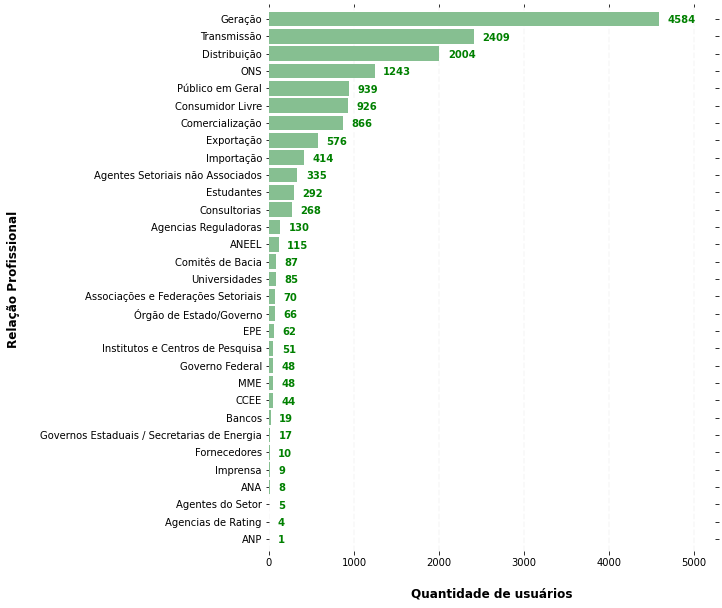

In [24]:
ax = df_cat_users.set_index('CATEGORIA').sort_values(by=['USUARIOS']).plot(kind='barh', figsize=(8, 10), color='#86bf91', zorder=2, width=0.85, legend=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

for i,v in enumerate(df_cat_users.USUARIOS.sort_values(ascending=True)):
    ax.text(v+100, i-.25, str(v), color='green', fontweight='bold')

  # Set x-axis label
ax.set_xlabel("Quantidade de usuários", labelpad=20, weight='bold', size=12)

 # Set y-axis label
ax.set_ylabel("Relação Profissional", labelpad=20, weight='bold', size=12)

x = ax.plot()

Repare que a maior quantidade de usuários estão relacionados aos Tipos de Agentes (Geração, Transmissão, Distribuição).

## Análise de dados por perfil de usuário

Abaixo exibiremos graficamente a relação da quantidade de usuários com os perfis. O Perfil, para nosso problema, será a identificação de um relacionamento único entre 1 ou mais categorias.

Exemplo:
    Usuários que tenham indicado apenas a categoria Geração, terá um perfil denominado *Geração*.\
    Usuários que tenham indicado a categoria Geração e Transmissão, terá um perfil denominado *Geração_Transmissão*.

In [26]:
#Crio a coluna PERFIL no dataframe
df['PERFIL'] = ""

for idx, values in df[df.columns[1:ind_col_inic_prod(df)]].iterrows():
    str_perfil = "_".join([x.replace(" ", "") for x in values.index if values[x] == 1])
    if len(str_perfil) > 0 :
        df.loc[idx, 'PERFIL'] = str_perfil
    else:
        df.loc[idx, 'PERFIL'] = "SEM_REL_PROF"
  

In [27]:
df_perfil_users = df.PERFIL.value_counts().reset_index().rename(columns = {'index':'RELACAO_PROFISSIONAL', 'PERFIL': 'USUARIOS'})

In [28]:
df_perfil_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   RELACAO_PROFISSIONAL  166 non-null    object
 1   USUARIOS              166 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.7+ KB


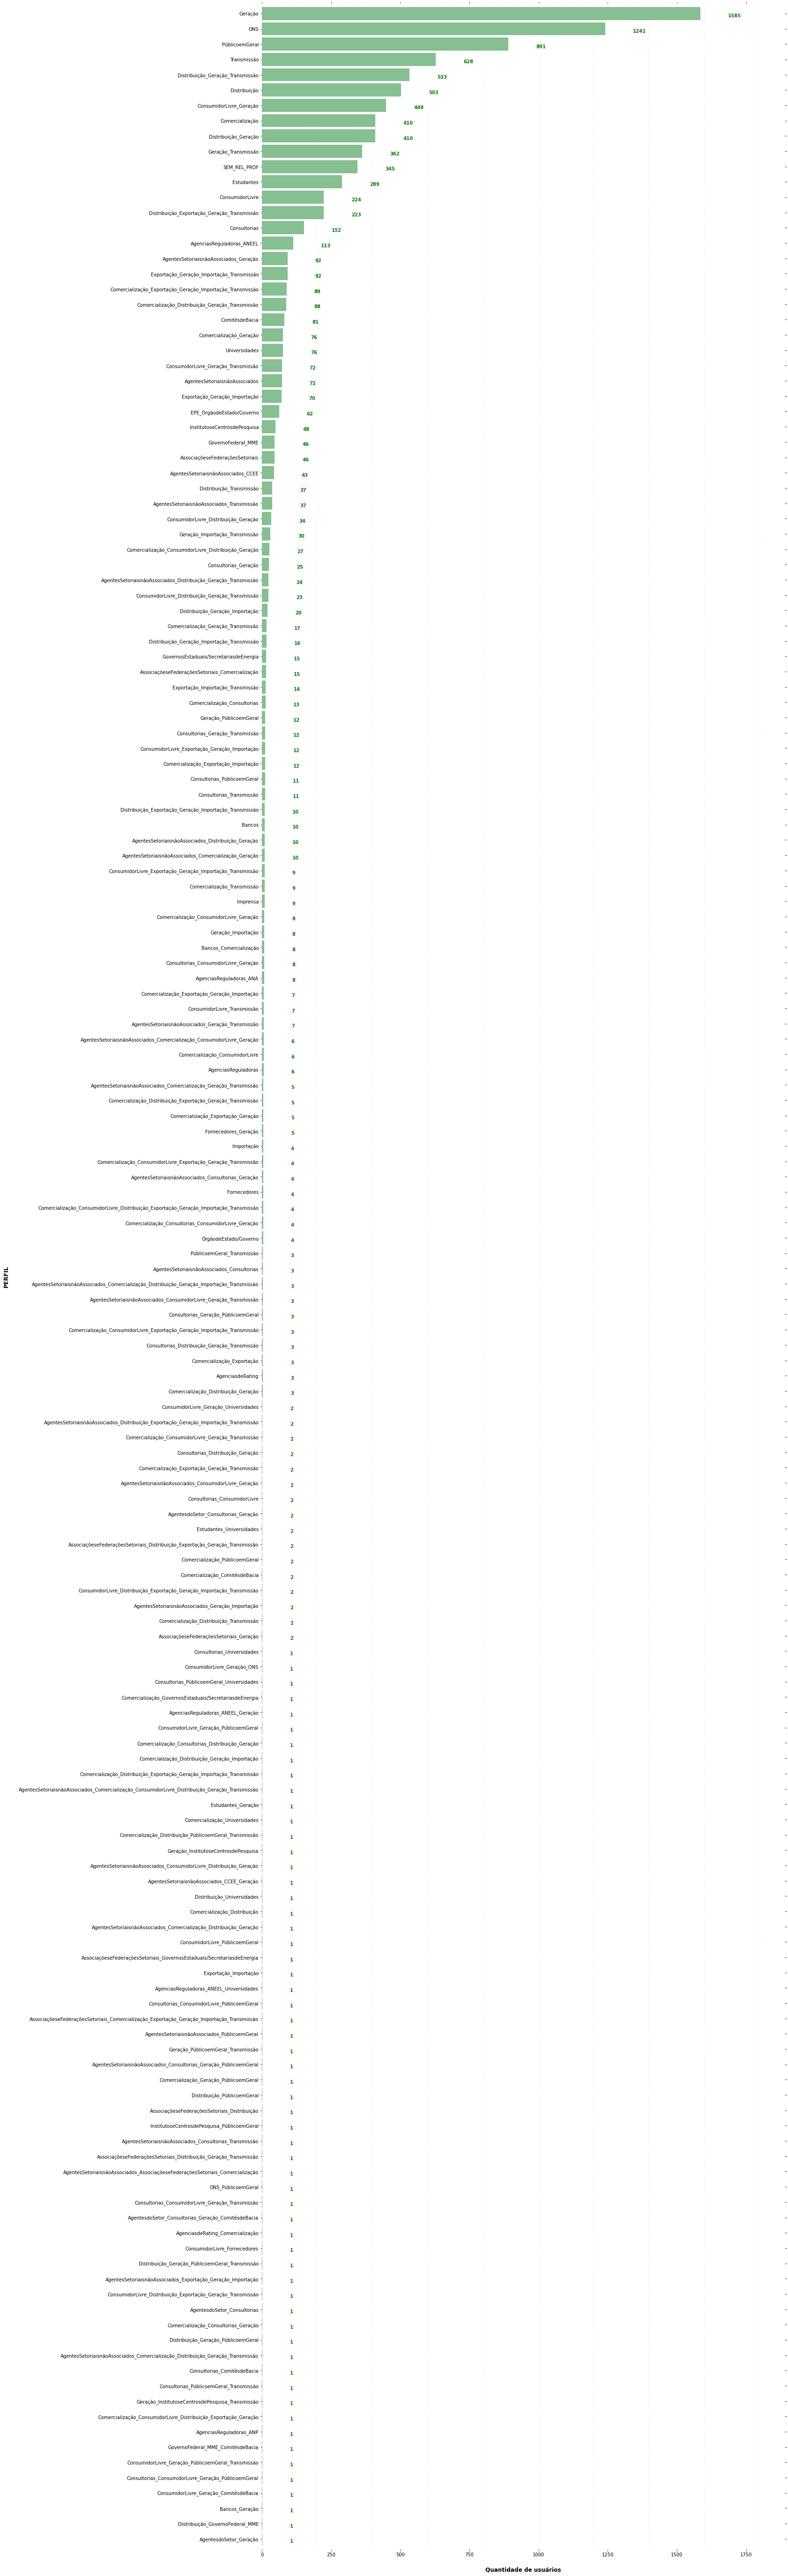

In [29]:
ax = df_perfil_users.set_index('RELACAO_PROFISSIONAL').sort_values(by=['USUARIOS']).plot(kind='barh', figsize=(20, 100), color='#86bf91', zorder=2, width=0.85, legend=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

for i,v in enumerate(df_perfil_users.USUARIOS.sort_values(ascending=True)):

    ax.text(int(v)+100, i-.25, str(v), color='green', fontweight='bold')


  # Set x-axis label
ax.set_xlabel("Quantidade de usuários", labelpad=20, weight='bold', size=12)

 # Set y-axis label
ax.set_ylabel("PERFIL", labelpad=20, weight='bold', size=12)

x = ax.plot()

Pode-se notar que perfis que tenham influencia da categoria Geração, possuem uma quantidade significativa de usuários.

Outra coisa que se pode reparar é a identificação de usuários que não possuem relação profissional nenhuma (*SEM_REL_PROF*).

In [31]:
#lista de registros que possuem usuários que não tem nenhuma relação profissional
lst_sem_rel_prof = []
for idx, values in df[df.columns[1:ind_col_inic_prod(df)]].iterrows():
    if len([x.replace(" ", "") for x in values.index if values[x] == 1]) == 0:
        lst_sem_rel_prof.append(idx)



## Análise dos produtos associados pelos usuários

Visualizamos a quantidade de usuários por produto.

In [32]:
df_prod_users =  df[df.columns[ind_col_inic_prod(df):]].T.sum(axis=1).reset_index().rename(columns = {'index':'PRODUTOS', 0: 'USUARIOS'})

In [33]:
df_prod_users.drop(df_prod_users[df_prod_users.PRODUTOS == 'PERFIL'].index.values[0],inplace=True)

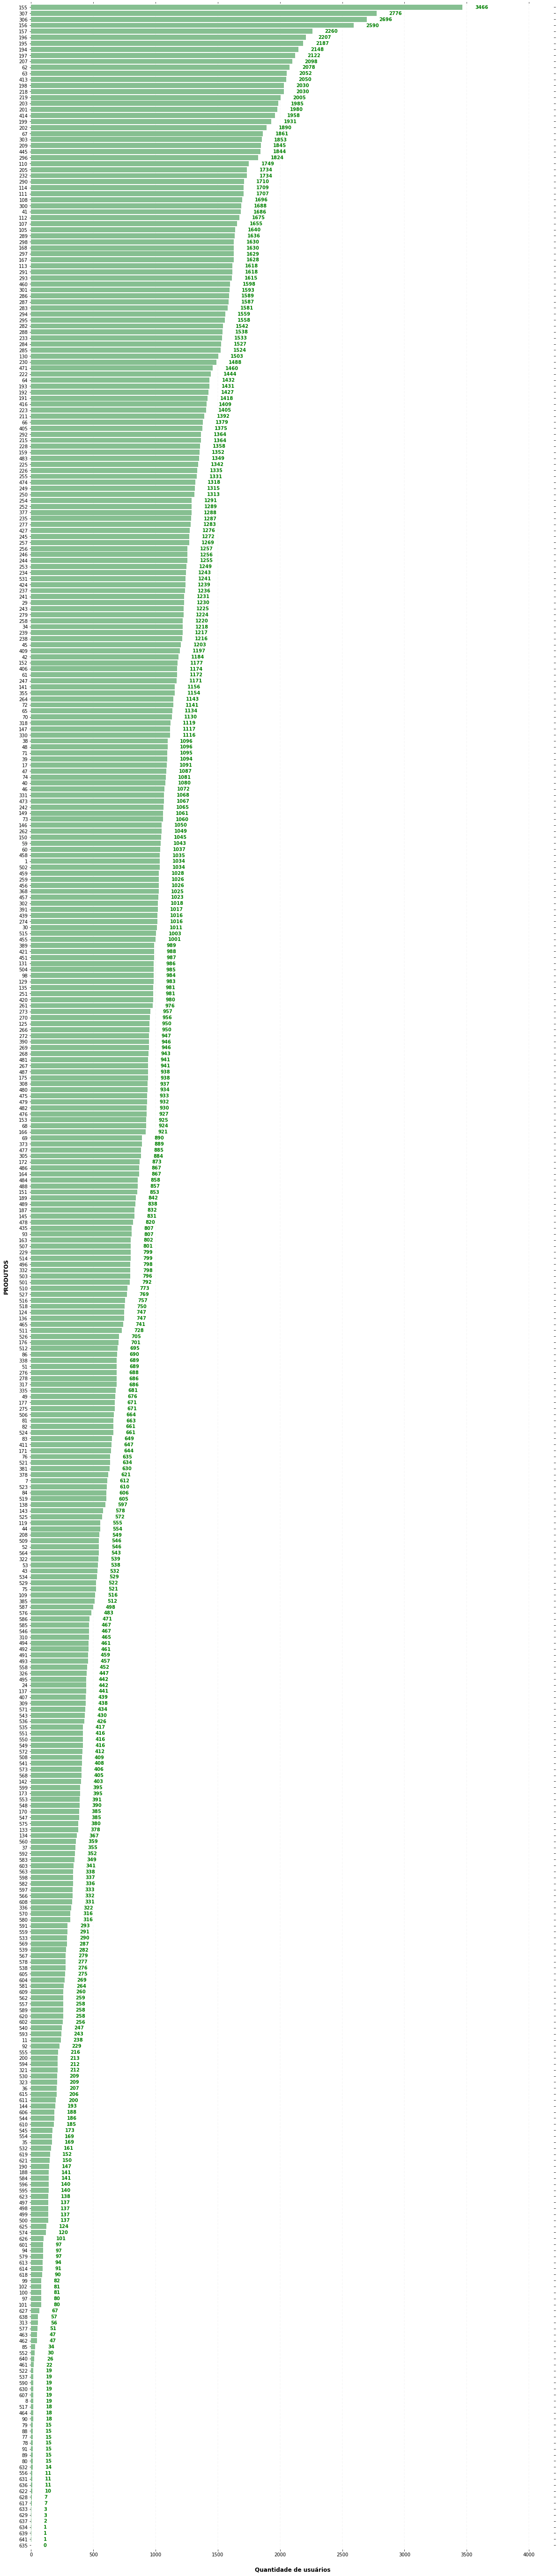

In [34]:
ax = df_prod_users.set_index('PRODUTOS').sort_values(by=['USUARIOS']).plot(kind='barh', figsize=(20, 100), color='#86bf91', zorder=2, width=0.85, legend=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

for i,v in enumerate(df_prod_users.USUARIOS.sort_values(ascending=True)):

    ax.text(int(v)+100, i-.25, str(v), color='green', fontweight='bold')


  # Set x-axis label
ax.set_xlabel("Quantidade de usuários", labelpad=20, weight='bold', size=12)

 # Set y-axis label
ax.set_ylabel("PRODUTOS", labelpad=20, weight='bold', size=12)

x = ax.plot()

# Dividindo a base em Treino e Teste

Separa a base de treino (80%) e teste (20%) e associe-as as variáveis X_train, X_test

In [35]:
total_reg = df.shape[0]
# 20% do total de registros 
print('Quantidade de registros para a base de testes: ',int(total_reg * 0.2))

Quantidade de registros para a base de testes:  2028


In [36]:
df_perfil = df.copy()

In [37]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()
X_temp = pd.DataFrame()
for x in df_perfil_users.RELACAO_PROFISSIONAL:
    if len(df[df.PERFIL == x]) > 10:
        X_train_temp, X_test_temp = train_test_split(df[df.PERFIL == x],test_size=0.2)
        X_train = pd.concat([X_train, X_train_temp])
        X_test = pd.concat([X_test, X_test_temp])
    else:
        X_temp = pd.concat([X_temp, df[df.PERFIL == x]])

X_train_temp, X_test_temp = train_test_split(X_temp,test_size=0.2)
X_train = pd.concat([X_train, X_train_temp])
X_test = pd.concat([X_test, X_test_temp])

In [38]:
X_train.drop(columns=['PERFIL','id_pessoa'], inplace=True)
X_test.drop(columns=['PERFIL','id_pessoa'], inplace=True)

In [39]:
print('Dimensões das matrizes de treino e de teste, respectivamente:')
X_train.shape,X_test.shape

Dimensões das matrizes de treino e de teste, respectivamente:


((8092, 454), (2051, 454))

In [40]:
df = df.drop(['id_pessoa'],axis=1) #exclui a coluna ID do df

#O que é uma RN Autoencoder?

https://www.deeplearningbook.com.br/introducao-aos-autoencoders/

Os Autoencoders são uma técnica de aprendizado não supervisionado, na qual usamos as redes neurais para a tarefa de aprendizado de representação. Especificamente, projetaremos uma arquitetura de rede neural de modo a impor um gargalo na rede que força uma representação de conhecimento compactada da entrada original. Se os recursos de entrada fossem independentes um do outro, essa compressão e reconstrução subsequente seriam uma tarefa muito difícil. No entanto, se houver algum tipo de estrutura nos dados (ou seja, correlações entre os recursos de entrada), essa estrutura poderá ser aprendida e consequentemente aproveitada ao forçar a entrada através do gargalo da rede.

Autoencoders (AE) são redes neurais que visam copiar suas entradas para suas saídas. Eles trabalham compactando a entrada em uma representação de espaço latente e, em seguida, reconstruindo a saída dessa representação. Esse tipo de rede é composto de duas partes:

Codificador (Encoder): é a parte da rede que compacta a entrada em uma representação de espaço latente (codificando a entrada). Pode ser representado por uma função de codificação h = f (x).

Decodificador (Decoder): Esta parte tem como objetivo reconstruir a entrada da representação do espaço latente. Pode ser representado por uma função de decodificação r = g (h).



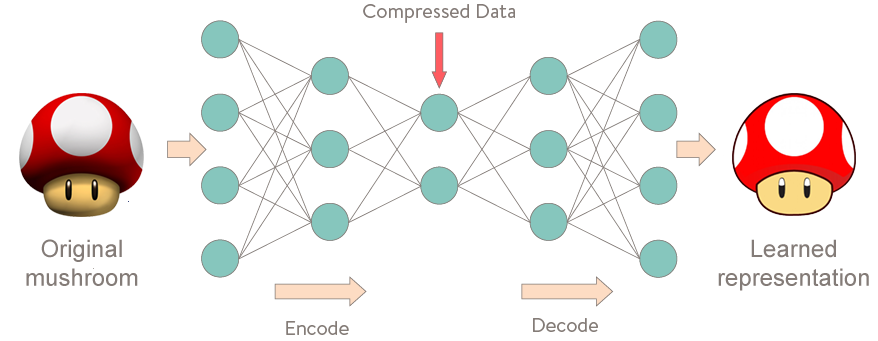

***Talvez aqui encaixe uma explicação melhor sobre uso de autoencoder em problemas de sistemas de recomendação***

Com essas caraterísticas, as RNs Autoencoders são usadas em sistemas de recomendação para filtragem colaborativa, onde o usuário interage com o conteúdo. No nosso caso, temos a relação em uma matriz de quais produtos (colunas) foram assinados por cada usuário (linha). Representado por 0 (não assinado) e 1(assinado).\
A partir desta matriz usuário x produto, podemos de fato comprimí-la  por ser esparsa e depois reconstruir uma versão completa da matriz contendo uma aproximação de todos os valores que antes eram nulos. Algo como: 

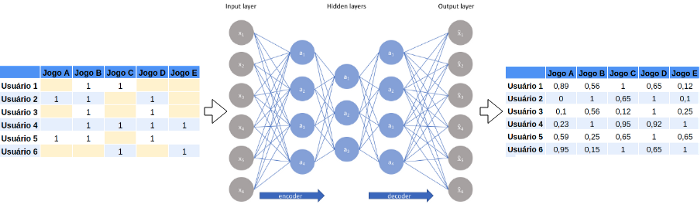

Ao final, basta apenas ordenar as recomendações por usuário, selecionando aquelas de maior pontuação.

# Configurando uma RN Autoencoder

Utilizando a bibliote Keras do Tensorflow para estrutura uma rede neural.

In [41]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils

from keras import Model, Sequential
from keras.layers import Dense, Dropout

#from keras.optimizers import SGD

Utilizando a classe Sequential do Keras, por ser de fácil entendimento e manipulação.

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential?hl=es-419

In [42]:
RN = Sequential()

Criando alguns hiperparâmetros para configuração da rede neural.

In [43]:
# Função utilizada para calcular heuristicamente o tamanho da próxima camada
def sizeNextLayer(size):
    if size % 2 != 0:
        size = size - 1        
    next = int(size / 2)
    if next % 2 != 0:
        return next - 1
    else:
        return next 

In [44]:
original_dim = X_train.columns.size 
saida_dim = original_dim 
intermediate_dim0 = sizeNextLayer(original_dim)
intermediate_dim1 = sizeNextLayer(intermediate_dim0)
intermediate_dim2 = sizeNextLayer(intermediate_dim1)
latent_dim = sizeNextLayer(intermediate_dim2)

Criando a camada de codificação (encoder)

In [45]:
RN.add(Dense(intermediate_dim0,input_shape = (original_dim,),activation = 'relu', name='entrada'))
RN.add(Dense(intermediate_dim1,activation = 'relu',name='enc_0'))
RN.add(Dense(intermediate_dim2,activation = 'relu',name='enc_1'))
RN.add(Dense(latent_dim,activation = 'relu',name='enc_2'))

In [ ]:
#RN.add(Dropout(0.8, name='dropout'))

Criando a camada de decodificação/reconstrução (decoder)

In [46]:
RN.add(Dense(intermediate_dim2,activation = 'relu',name='dec_2'))
RN.add(Dense(intermediate_dim1,activation = 'relu',name='dec_1'))
RN.add(Dense(intermediate_dim0,activation = 'relu',name='dec_0'))
RN.add(Dense(saida_dim,activation = 'linear',name='saida')) 

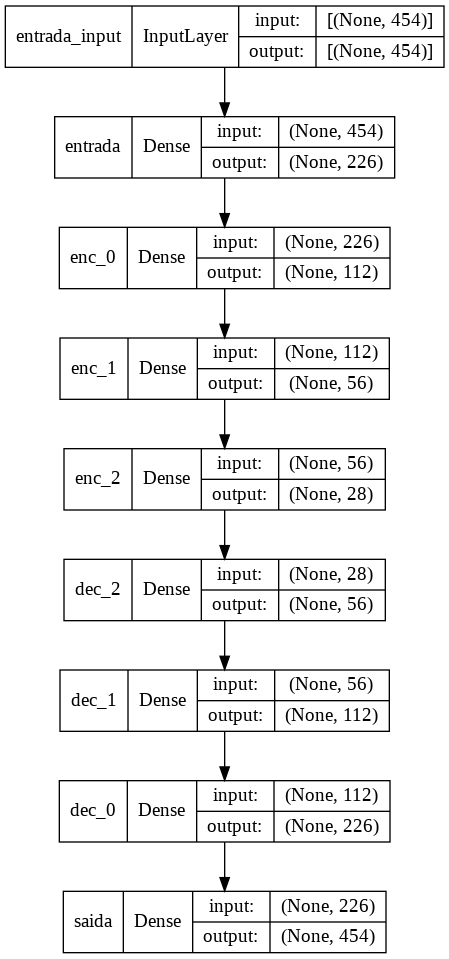

In [47]:
utils.plot_model(RN,show_shapes=True)

In [48]:
RN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 entrada (Dense)             (None, 226)               102830    
                                                                 
 enc_0 (Dense)               (None, 112)               25424     
                                                                 
 enc_1 (Dense)               (None, 56)                6328      
                                                                 
 enc_2 (Dense)               (None, 28)                1596      
                                                                 
 dec_2 (Dense)               (None, 56)                1624      
                                                                 
 dec_1 (Dense)               (None, 112)               6384      
                                                                 
 dec_0 (Dense)               (None, 226)               2

# Compilando e Treinando a RN

In [49]:
RN.compile(optimizer = 'Adam', loss = 'mean_squared_error')


De acordo com vários experimentos realizados, alterando o total de épocas, chegou-se a conclusão que 200 épocas são satisfatórios para um bom desempenho do modelo.

Outro ponto importante é que, em RNs autoencoders, espera-se na saída o que se aplicou na entrada. Contudo, para o nosso problema, temos que fazer com que o modelo possa nos recomoendar apenas produtos e não informações da pessoa (que são as n primeiras colunas da matriz).\
Logo, o vetor de saída, para o nosso problema tem um número menor de posições.

In [50]:
epcs = 200
trainedRN = RN.fit(X_train,X_train,epochs = epcs, verbose = 2, validation_split=0.1, shuffle=True, batch_size=64)
#validation_split = Fração dos dados de treinamento a serem usados ​​como dados de validação. O modelo separará essa fração dos dados de treinamento, não treinará nela e avaliará a perda e quaisquer métricas do modelo nesses dados no final de cada época.

Epoch 1/200
114/114 - 3s - loss: 0.0390 - val_loss: 0.0338 - 3s/epoch - 28ms/step
Epoch 2/200
114/114 - 0s - loss: 0.0258 - val_loss: 0.0278 - 456ms/epoch - 4ms/step
Epoch 3/200
114/114 - 0s - loss: 0.0215 - val_loss: 0.0253 - 484ms/epoch - 4ms/step
Epoch 4/200
114/114 - 0s - loss: 0.0195 - val_loss: 0.0238 - 487ms/epoch - 4ms/step
Epoch 5/200
114/114 - 0s - loss: 0.0181 - val_loss: 0.0227 - 470ms/epoch - 4ms/step
Epoch 6/200
114/114 - 0s - loss: 0.0169 - val_loss: 0.0215 - 447ms/epoch - 4ms/step
Epoch 7/200
114/114 - 0s - loss: 0.0160 - val_loss: 0.0209 - 440ms/epoch - 4ms/step
Epoch 8/200
114/114 - 0s - loss: 0.0154 - val_loss: 0.0209 - 490ms/epoch - 4ms/step
Epoch 9/200
114/114 - 0s - loss: 0.0149 - val_loss: 0.0199 - 454ms/epoch - 4ms/step
Epoch 10/200
114/114 - 0s - loss: 0.0144 - val_loss: 0.0195 - 480ms/epoch - 4ms/step
Epoch 11/200
114/114 - 0s - loss: 0.0141 - val_loss: 0.0194 - 488ms/epoch - 4ms/step
Epoch 12/200
114/114 - 0s - loss: 0.0135 - val_loss: 0.0191 - 446ms/epoch - 

# Verificando a qualidade do modelo

A quantidade de épocas, tamanho do lote, entre outros parâmetros vai depender do problema. O ideal é treinar até que a curva de loss se estabilize e o erro pare de reduzir.

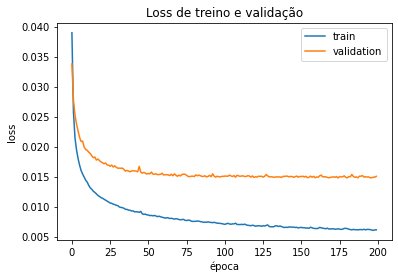

In [51]:
# Gráfico do treinamento: custo do treino e validação
plt.plot(trainedRN.history['loss'], label='train')
plt.plot(trainedRN.history['val_loss'], label='validation')
plt.title('Loss de treino e validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

Abaixo calculo o MSE (Erro quadrático médio) do modelo na base de teste.

In [52]:
score = RN.evaluate(X_test, X_test, verbose = 1) 
score

65/65 [==============================] - 0s 4ms/step - loss: 0.0114


0.011438547633588314

# Realizando a previsão

Selecionando aleatoriamente um usuário do dataframe de teste para utiliza-o como teste para seleção de um conjunto de produtos a serem recomendados à este usuário.

Este registro terá informações de uma pessoa que pode ou não ter assinado um ou mais produtos do SINTEGRE.

In [53]:
#Função que retorna uma linha aleatória do conjunto de teste
def retorna_linha_teste (df_parm):
  ind_rd = rd.randint(0,df_parm[df_parm.columns[0]].count())
  while len(df_parm[df_parm.index == ind_rd]) != 1:
    ind_rd = rd.randint(0,df_parm[df_parm.columns[0]].count())
  return ind_rd

In [54]:
id_linha = retorna_linha_teste(X_test)
print('Número do registro que será utilizado no teste: ',id_linha)

Número do registro que será utilizado no teste:  450


Imprimindo o conteúdo deste registro selecionado.

In [55]:
X_test[X_test.index == id_linha].values

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Defino uma função que retorna a posição (índice) do vetor que contém um valor diferente de 0 (zero)


In [56]:
def posicao_vet (vet):
  vetor = []
  cont = 0
  for i in vet: 
    if i > 0:
      vetor.append(cont)
    cont = cont+1
  return vetor

Abaixo, realizo a previsão para o registro selecionado

In [57]:
Y = RN.predict (X_test[X_test.index == id_linha])

Abaixo imprimo o conteúdo do resultado da previsão. 

In [58]:
Y

array([[-6.96049421e-04,  4.06043977e-03, -6.10962015e-05,
        -2.05818936e-02, -8.61114222e-06,  4.06923145e-03,
         2.27655837e-05, -2.54036102e-04, -1.22919519e-04,
         7.56958325e-04,  2.14284867e-01, -1.99501365e-02,
         5.14573038e-01,  9.43915248e-01,  4.06827865e-04,
        -1.00192934e-01,  6.18741438e-02, -1.70349245e-04,
         1.21193933e+00, -1.99367478e-05, -3.64602369e-04,
        -2.74096616e-02, -2.24527859e-04, -1.52297638e-04,
        -2.48891738e-04, -1.31500810e-02,  5.17997076e-04,
        -7.75302527e-03,  3.21405679e-02, -2.97174230e-03,
        -2.23889165e-02,  4.27702814e-03,  1.88418478e-03,
        -4.80427966e-03,  1.32377315e-02,  5.13077527e-03,
        -5.30933253e-02,  2.04011127e-02, -3.32454965e-03,
         1.85152777e-02,  6.10074215e-03,  2.11835578e-02,
         3.41675058e-03, -1.96389854e-02, -1.22862123e-02,
        -2.22627297e-02,  7.72641972e-02,  1.28892679e-02,
        -2.99865566e-02, -2.53900234e-02,  2.37916578e-0

In [59]:
Y.min()


-0.3049457

In [60]:
Y.max()

1.2119393

**Acima observa-se o resultado do modelo de recomendação para este usuário selecionado. O papel final de uma solução deste tipo é ordenar e selecionar os produtos que possuem pesos maiores deste resultado, separando aqueles que o usuário já assina. Esses serão os produtos que o modelo recomenda para este usuário.**

Agora vamos representar graficamente o que estou afirmando acima.

Primeiramente crio um dataframe contendo produtos e o perfil de cada usuário.

In [61]:
df_perfil_test = df_perfil[(df_perfil.columns[ind_col_inic_prod(df_perfil):])].loc[df_perfil.index.isin(X_test.index)]

In [62]:
df_perfil_test.head()

,1,7,8,11,17,24,29,30,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,51,52,53,59,60,61,62,63,64,65,66,67,68,69,70,71,...,599,601,602,603,604,605,606,607,608,609,610,611,613,614,615,617,618,619,620,621,622,623,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,PERFIL
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Distribuição_Geração_Transmissão
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ConsumidorLivre_Geração
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ConsumidorLivre
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Geração_Transmissão
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Distribuição_Exportação_Geração_Transmissão


Abaixo realizo a previsão para cada usuário que está contido na base de teste.

In [63]:
%%time
# Criar um dataframe com todas as recomendações do dataset de validação
df_recsys_teste = pd.concat([(RN.predict(X_test.loc[[idx_user]]) * (X_test.loc[[idx_user]] == 0)) for idx_user in  X_test.index])

CPU times: user 5min 16s, sys: 19.4 s, total: 5min 35s
Wall time: 5min 17s


Como se criou um novo dataframe contendo agora as previsões, associo o perfil que identificamos no EDA.\
E crio algumas funções de apoio para a geração do gráfico.

In [64]:
# Associa o perfil
df_recsys_teste['PERFIL'] = ''
for i,v in df_recsys_teste.iterrows():
    df_recsys_teste.loc[i, 'PERFIL'] = df_perfil.loc[i,'PERFIL']

In [65]:
def last_perf_column(lst_columns):
    column = 0
    for x in lst_columns:
        try:
            int(x)
            return column
        except:
            column += 1  

# Passar os dados do usuário desejado para retornar os produtos assinados por este: exemplo --> get_produtos_assinados(df.loc[[0]])
def get_produtos_assinados(df):
    last_id_colum = last_perf_column(df.columns)
    lst_values = df[df.columns[last_id_colum:]].values[0]
    lst_id_columns = np.where(lst_values == 0)
    return df.columns[last_id_colum:][lst_id_columns]

# Passar os dados do usuário desejado para retornar os top(x) produtos recomendados por este: exemplo --> get_produtos_assinados(df.loc[[0]], 20)
def get_produtos_recomendados_topn(df, top=10):
    last_id_colum = last_perf_column(df.columns)
    df_temp = df[df.columns[last_id_colum:]].T
    return list(df_temp[df_temp[df_temp.columns[0]] > 0].sort_values(by=df_temp.columns[0], ascending=False)[:top].index)

# Passar os dados do usuário desejado para retornar os n produtos aleatórios recomendados por este: exemplo --> get_produtos_assinados(df.loc[[0]], 20)
def get_produtos_recomendados_random(df, n=10):
    last_id_colum = last_perf_column(df.columns)
    df_temp = df[df.columns[last_id_colum:]].T
    return list(df_temp[df_temp[df_temp.columns[0]] > 0].sort_values(by=df_temp.columns[0], ascending=False)[:50].sample(n).index)



In [66]:
def get_produtos_assinados_recomendados(df,  df_produtos, top=10):
        x_axes = list(df_produtos.nom_pocesso_raiz.drop_duplicates().values)
        
        lst_assinados = list(map(int, get_produtos_assinados(df)))
        assindados = df_produtos[df_produtos.id_produto.isin(lst_assinados)]['nom_pocesso_raiz'].value_counts(dropna=False).reset_index().set_index('index').T.reset_index(drop=True).loc[0]
        assindados = [assindados[x] if x in assindados.index else 0 for x in x_axes ]
        assindados_normal = assindados/max(assindados)
        
        lst_recomendados = list(map(int, get_produtos_recomendados_topn(df, top)))
        recomendados = df_produtos[df_produtos.id_produto.isin(lst_recomendados)]['nom_pocesso_raiz'].value_counts(dropna=False).reset_index().set_index('index').T.reset_index(drop=True).loc[0]
        recomendados = [recomendados[x] if x in recomendados.index else 0 for x in x_axes ]
        recomendados_normal = recomendados/max(recomendados)
        
        return assindados, assindados_normal, recomendados, recomendados_normal

O objetivo, com a função abaixo, é gerar um gráfico que seleciona (aleatoriamente) 9 usuários de um deteminado perfil da base de teste, que contém previsões, e exiba graficamente a quantiade de produtos recomendados por processo.

In [67]:
def plot_analise_recomendacoes(df,  df_produtos, top=10 ,Perfil = ''):
    try:
        x_axes = list(df_produtos.nom_pocesso_raiz.drop_duplicates().values)

        if df.shape[0] >= 9:
            lst_idx_values = np.random.choice(df.index, 9, replace=False)            
        else:
            lst_idx_values = np.random.choice(df.index, df.shape[0], replace=False)

                       
        fig, axs = plt.subplots(3,3, figsize=(15, 8), sharex=True, sharey=True)
        fig.suptitle('Recomendações de produtos do SINTEGRE. Perfil: ' + Perfil )
        
        for i, ax in enumerate(axs.flat):

            if df.shape[0]-1 < i:
                ax.text(0.5, 0.5,"No data")
                ax.scatter(x_axes, ([0] * len(x_axes)), color='darkblue', 
                             alpha=0,
                             s = 0, label='Assinados')
                ax.scatter(x_axes, ([0] * len(x_axes)), color='purple', 
                             alpha=0,
                             s = 0, label='Recomendados')
                ax.set_xticklabels(x_axes, rotation=90)
            else:
                assindados, assindados_normal, recomendados, recomendados_normal = get_produtos_assinados_recomendados(df.loc[[lst_idx_values[i]]],  df_produtos, top)
                ax.scatter(x_axes, assindados, color='darkblue', 
                             alpha=0.5,
                             s = assindados_normal * 500, label='Assinados')
                ax.scatter(x_axes, recomendados, color='purple', 
                             alpha=0.5,
                             s = recomendados_normal * 500,  label='Recomendados')

                ax.set_xticklabels(x_axes, rotation=90)
                if i == 0:
                    legend = ax.legend(bbox_to_anchor=(4.0,1.0))
                    for handle in legend.legendHandles:
                        handle.set_sizes([80])
            #ax.set_yticklabels(list(range(0,1500)))
        
        # set labels
        #plt.setp(axs[-1:, 0], xlabel='Processos', rotation=45)
        plt.setp(axs[:, 0], ylabel='Quantidade de Produtos')
        
        a = plt.plot()
        
        Perfil = Perfil.replace('/','-')
        plt.savefig('SintegreRecsys_' + Perfil + '.jpg')
        #plt.close(fig)
    except Exception as error:
        print(error)

In [ ]:
# Gera gráficos de todos os perfis

#for perf in df_recsys_teste.PERFIL.drop_duplicates().values:
#    plot_analise_recomendacoes(df_recsys_teste[df_recsys_teste.PERFIL == perf].drop(columns=['PERFIL']), df_produtos, 20, perf)

In [69]:
#listar todos os perfis
df_recsys_teste.PERFIL.drop_duplicates()

2455                                              Geração
3407                                                  ONS
1653                                       PúblicoemGeral
2304                                          Transmissão
2472                     Distribuição_Geração_Transmissão
                              ...                        
1184                 Comercialização_Distribuição_Geração
5753                      Comercialização_ConsumidorLivre
3484                 Consultorias_ConsumidorLivre_Geração
6566                       ConsumidorLivre_PúblicoemGeral
336     Comercialização_Distribuição_Exportação_Geraçã...
Name: PERFIL, Length: 96, dtype: object

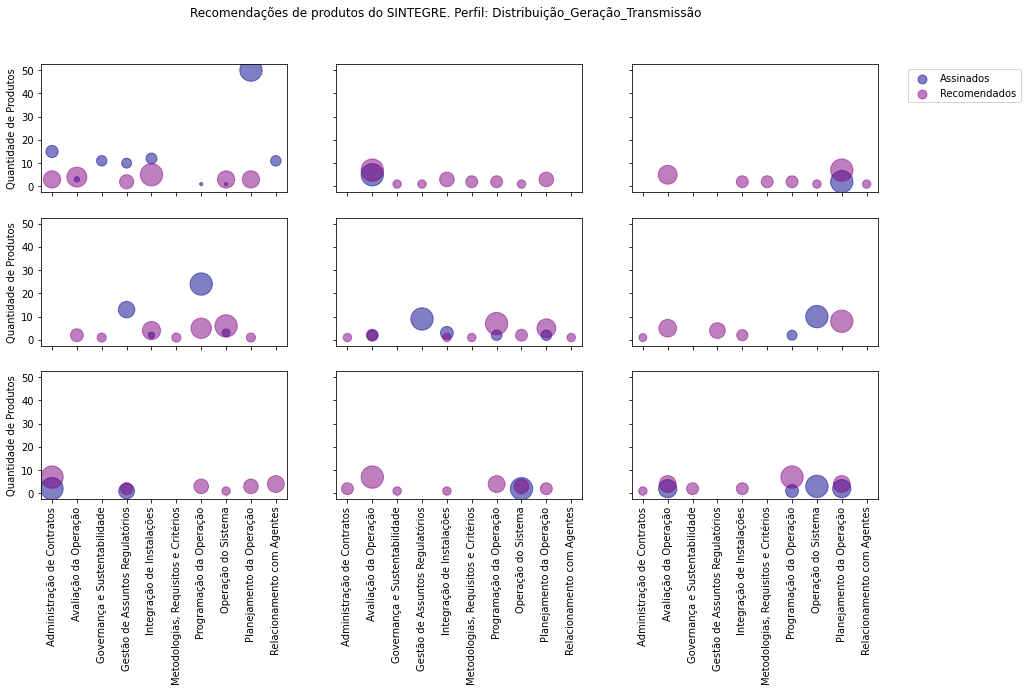

In [70]:
# Gera gráfico apenas de um perfil
perf='Distribuição_Geração_Transmissão'#'Geração'
plot_analise_recomendacoes(df_recsys_teste[df_recsys_teste.PERFIL == perf].drop(columns=['PERFIL']), df_produtos, 20, perf)
# o 20 é quantidade de produtos que se quer recomendar

Cada gráfico representa cada usuário 